# Load the required modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, AdamW, Adamax
from tensorflow.keras.utils import to_categorical, plot_model

from keras.src import ops
from keras.src.api_export import keras_export
from keras.src.optimizers import optimizer

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score

from tensorflow.keras.optimizers import Optimizer
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.python.util.tf_export import keras_export
from keras import backend as K


# Implement Our Optimizers (OurAdamW, OurAdam, OurAdaMax)

## Our Adam

In [ ]:
@keras_export(["keras.optimizers.OurAdam"])
class OurAdam(optimizer.Optimizer):
    def __init__(self,learning_rate=0.001,
        beta_1=0.9,beta_2=0.999,epsilon=1e-7,
        amsgrad=False,name="OurAdam",**kwargs,
    ):
        super().__init__(
            learning_rate=learning_rate,
            name=name,
            **kwargs,
        )
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.amsgrad = amsgrad

    def build(self, var_list):
        if self.built:
            return
        super().build(var_list)
        self._m = []
        self._v = []
        for var in var_list:
            self._m.append(self.add_variable_from_reference(var, "m"))
            self._v.append(self.add_variable_from_reference(var, "v"))
        if self.amsgrad:
            self._v_hat = []
            for var in var_list:
                self._v_hat.append(
                    self.add_variable_from_reference(var, "v_hat"))

    def update_step(self, gradient, variable, learning_rate):
        lr = ops.cast(learning_rate, variable.dtype)
        gradient = ops.cast(gradient, variable.dtype)
        t = ops.cast(self.iterations + 1, variable.dtype)
        beta1_power = ops.power(ops.cast(self.beta_1, variable.dtype), t)
        beta2_power = ops.power(ops.cast(self.beta_2, variable.dtype), t)

        m = self._m[self._get_variable_index(variable)]
        v = self._v[self._get_variable_index(variable)]

        alpha = lr * ops.sqrt(1 - beta2_power) / (1 - beta1_power)

        self.assign_add(m, (gradient - m) * (1 - self.beta_1))
        self.assign_add(v, (ops.square(gradient) - v) * (1 - self.beta_2))

        if self.amsgrad:
            v_hat = self._v_hat[self._get_variable_index(variable)]
            self.assign(v_hat, ops.maximum(v_hat, v))
            v = v_hat

        self.assign_sub(
            variable,
            alpha * m / (ops.sqrt(v) + self.epsilon),
        )

    def get_config(self):
        config = super().get_config()
        config.update({
            "beta_1": self.beta_1,
            "beta_2": self.beta_2,
            "epsilon": self.epsilon,
            "amsgrad": self.amsgrad,
        })
        return config

## Our Adamax

In [ ]:
@register_keras_serializable(package="Custom")
class OurAdaMax(Optimizer):
    """A custom AdaMax optimizer following the new-style Keras optimizer API."""
    def __init__(
        self,
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-8,
        name="OurAdaMax",
        **kwargs
    ):
        super().__init__(name=name, learning_rate=learning_rate, **kwargs)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

    def build(self, var_list):
        """Initialize optimizer state for each variable."""
        super().build(var_list)
        self._m = []
        self._u = []
        # Create 'm' and 'u' state for each variable
        for var in var_list:
            self._m.append(self.add_variable_from_reference(var, "m"))
            self._u.append(self.add_variable_from_reference(var, "u"))

    def update_step(self, gradient, variable, learning_rate):
        """Apply one update step to the given variable."""
        var_index = self._get_variable_index(variable)

        m = self._m[var_index]
        u = self._u[var_index]

        # Convert the Python float to the same dtype as `variable`
        lr_t = tf.cast(learning_rate, variable.dtype)
        # Current iteration (1-based)
        t = tf.cast(self.iterations + 1, variable.dtype)

        # Bias-corrected learning rate for AdaMax
        alpha_t = lr_t / (1.0 - tf.pow(self.beta_1, t))

        # Update first moment m_t
        m_t = self.beta_1 * m + (1.0 - self.beta_1) * gradient
        self.assign(m, m_t)

        # Update the exponentially weighted infinity norm
        u_t = tf.maximum(self.beta_2 * u, tf.abs(gradient))
        self.assign(u, u_t)

        # Perform the parameter update
        var_update = variable - alpha_t * (m_t / (u_t + self.epsilon))
        self.assign(variable, var_update)

    def get_config(self):
        """Returns the config of the optimizer."""
        config = super().get_config()
        config.update({
            "beta_1": self.beta_1,
            "beta_2": self.beta_2,
            "epsilon": self.epsilon,
        })
        return config


## OurAdamW

In [ ]:
@keras_export("keras.optimizers.OurAdamW")
class OurAdamW(optimizer.Optimizer):
    def __init__(self, learning_rate=1e-5, beta_1=0.9, beta_2=0.999,
                 epsilon=1e-8, weight_decay=1e-2, name="OurAdamW", **kwargs):
        super().__init__(learning_rate=learning_rate, name=name, **kwargs)
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        self.weight_decay = weight_decay

    def build(self, var_list):
        if self.built:
            return
        super().build(var_list)
        self._m = []
        self._v = []
        for var in var_list:
            self._m.append(self.add_variable_from_reference(var, "m"))
            self._v.append(self.add_variable_from_reference(var, "v"))

    def update_step(self, gradient, variable, learning_rate):
        lr = ops.cast(learning_rate, variable.dtype)
        gradient = ops.cast(gradient, variable.dtype)
        t = ops.cast(self.iterations + 1, variable.dtype)
        m = self._m[self._get_variable_index(variable)]
        v = self._v[self._get_variable_index(variable)]

        # Update moments first
        self.assign_add(m, (gradient - m) * (1 - self.beta_1))
        self.assign_add(v, (ops.square(gradient) - v) * (1 - self.beta_2))

        # Apply bias correction
        m_hat = m / (1 - ops.power(self.beta_1, t))
        v_hat = v / (1 - ops.power(self.beta_2, t))

        # Apply weight decay
        if self.weight_decay != 0:
            self.assign_sub(variable, lr * self.weight_decay * variable)

        # Update parameters with bias-corrected moments
        update_value = lr * m_hat / (ops.sqrt(v_hat) + self.epsilon)
        self.assign_sub(variable, update_value)

    def get_config(self):
        config = super().get_config()
        config.update({
            "beta_1": self.beta_1,
            "beta_2": self.beta_2,
            "epsilon": self.epsilon,
            "weight_decay": self.weight_decay,
        })
        return config

# Load MNIST Dataset

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist

(mnist_x, mnist_y), _ = mnist.load_data()
mnist_x = mnist_x.astype('float32') / 255.0
mnist_x = np.expand_dims(mnist_x, -1)
mnist_y = to_categorical(mnist_y)

In [ ]:
def split_data(x, y):
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(m_train, y_train), (m_val, y_val), (m_test, y_test) = split_data(mnist_x, mnist_y)

# Modeling

## OurAdam vs Tf Adam

In [ ]:
def create_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(28, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

### OurAdam

In [ ]:
%%time
def compile_and_train(optimizer):
    model = create_model()
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(m_train, y_train, epochs=10, batch_size=64, validation_data=(m_val, y_val))
    return history
mnist_y = np.argmax(mnist_y, axis=-1)
print("Testing OurAdam optimizer")
our_adam_history = compile_and_train(OurAdam())

Testing OurAdam optimizer
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8456 - loss: 0.4585 - val_accuracy: 0.9838 - val_loss: 0.0588
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9845 - loss: 0.0509 - val_accuracy: 0.9845 - val_loss: 0.0517
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9886 - loss: 0.0373 - val_accuracy: 0.9883 - val_loss: 0.0381
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9916 - loss: 0.0265 - val_accuracy: 0.9873 - val_loss: 0.0427
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.9940 - loss: 0.0182 - val_accuracy: 0.9905 - val_loss: 0.0334
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9943 - loss: 0.0172 - val_accuracy: 0.9893 - val_loss: 0.0355
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9953 - loss: 0.0149 - val_accuracy: 0.9882 - val_loss: 0.0435
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9956 - l

### Tf Adam

In [ ]:
%%time
print("Testing TensorFlow Adam optimizer")
tf_adam_history = compile_and_train(optimizers.Adam(learning_rate=0.001))

Testing TensorFlow Adam optimizer
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8726 - loss: 0.4024 - val_accuracy: 0.9810 - val_loss: 0.0656
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9833 - loss: 0.0515 - val_accuracy: 0.9883 - val_loss: 0.0380
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9905 - loss: 0.0314 - val_accuracy: 0.9895 - val_loss: 0.0328
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9931 - loss: 0.0219 - val_accuracy: 0.9880 - val_loss: 0.0351
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9949 - loss: 0.0167 - val_accuracy: 0.9907 - val_loss: 0.0405
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9949 - loss: 0.0155 - val_accuracy: 0.9837 - val_loss: 0.0614
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9958 - loss: 0.0130 - val_accuracy: 0.9892 - val_loss: 0.0369
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy:

## OurAdamW vs TfAdamW

### OurAdamW

In [ ]:
%%time
print("Testing OurAdamW optimizer")
our_adamw_history = compile_and_train(OurAdamW(learning_rate=0.001))

Testing OurAdamW optimizer
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8707 - loss: 0.3991 - val_accuracy: 0.9820 - val_loss: 0.0641
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9838 - loss: 0.0511 - val_accuracy: 0.9875 - val_loss: 0.0443
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9898 - loss: 0.0328 - val_accuracy: 0.9843 - val_loss: 0.0529
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9930 - loss: 0.0233 - val_accuracy: 0.9877 - val_loss: 0.0367
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9932 - loss: 0.0216 - val_accuracy: 0.9898 - val_loss: 0.0344
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9948 - loss: 0.0165 - val_accuracy: 0.9895 - val_loss: 0.0361
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9951 - loss: 0.0152 - val_accuracy: 0.9857 - val_loss: 0.0458
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9958 - l

### Tf AdamW

In [ ]:
%%time
print("Testing Tf AdamW optimizer")
tf_adamw_history = compile_and_train(optimizers.AdamW(learning_rate=0.001))

Testing Tf AdamW optimizer
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8673 - loss: 0.3948 - val_accuracy: 0.9838 - val_loss: 0.0560
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9845 - loss: 0.0507 - val_accuracy: 0.9868 - val_loss: 0.0494
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9896 - loss: 0.0341 - val_accuracy: 0.9848 - val_loss: 0.0517
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9925 - loss: 0.0242 - val_accuracy: 0.9882 - val_loss: 0.0382
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9940 - loss: 0.0189 - val_accuracy: 0.9908 - val_loss: 0.0278
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9949 - loss: 0.0161 - val_accuracy: 0.9895 - val_loss: 0.0317
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9961 - loss: 0.0123 - val_accuracy: 0.9907 - val_loss: 0.0304
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9974 - 

## OurAdamax vs Tf Adamax

### OurAdamax

In [ ]:
%%time
print("Testing OurAdaMax optimizer")
our_adamax_history = compile_and_train(OurAdaMax(learning_rate=0.001))

Testing OurAdaMax optimizer
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8399 - loss: 0.4932 - val_accuracy: 0.9773 - val_loss: 0.0804
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9756 - loss: 0.0760 - val_accuracy: 0.9852 - val_loss: 0.0535
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9841 - loss: 0.0508 - val_accuracy: 0.9833 - val_loss: 0.0534
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9892 - loss: 0.0346 - val_accuracy: 0.9870 - val_loss: 0.0464
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9927 - loss: 0.0264 - val_accuracy: 0.9873 - val_loss: 0.0400
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9939 - loss: 0.0187 - val_accuracy: 0.9883 - val_loss: 0.0362
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9955 - loss: 0.0153 - val_accuracy: 0.9893 - val_loss: 0.0359
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9959 - 

### Tf Adamax

In [ ]:
%%time
print("Testing Tf AdaMax optimizer")
tf_adamax_history = compile_and_train(tf.keras.optimizers.Adamax(learning_rate=0.001))

Testing Tf AdaMax optimizer
Epoch 1/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8285 - loss: 0.5375 - val_accuracy: 0.9738 - val_loss: 0.0845
Epoch 2/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9762 - loss: 0.0786 - val_accuracy: 0.9758 - val_loss: 0.0801
Epoch 3/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9840 - loss: 0.0534 - val_accuracy: 0.9855 - val_loss: 0.0492
Epoch 4/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9882 - loss: 0.0371 - val_accuracy: 0.9875 - val_loss: 0.0442
Epoch 5/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9907 - loss: 0.0284 - val_accuracy: 0.9868 - val_loss: 0.0473
Epoch 6/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9938 - loss: 0.0214 - val_accuracy: 0.9892 - val_loss: 0.0374
Epoch 7/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9947 - loss: 0.0179 - val_accuracy: 0.9887 - val_loss: 0.0400
Epoch 8/10
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9962 -

# Evaluation

### Plot model

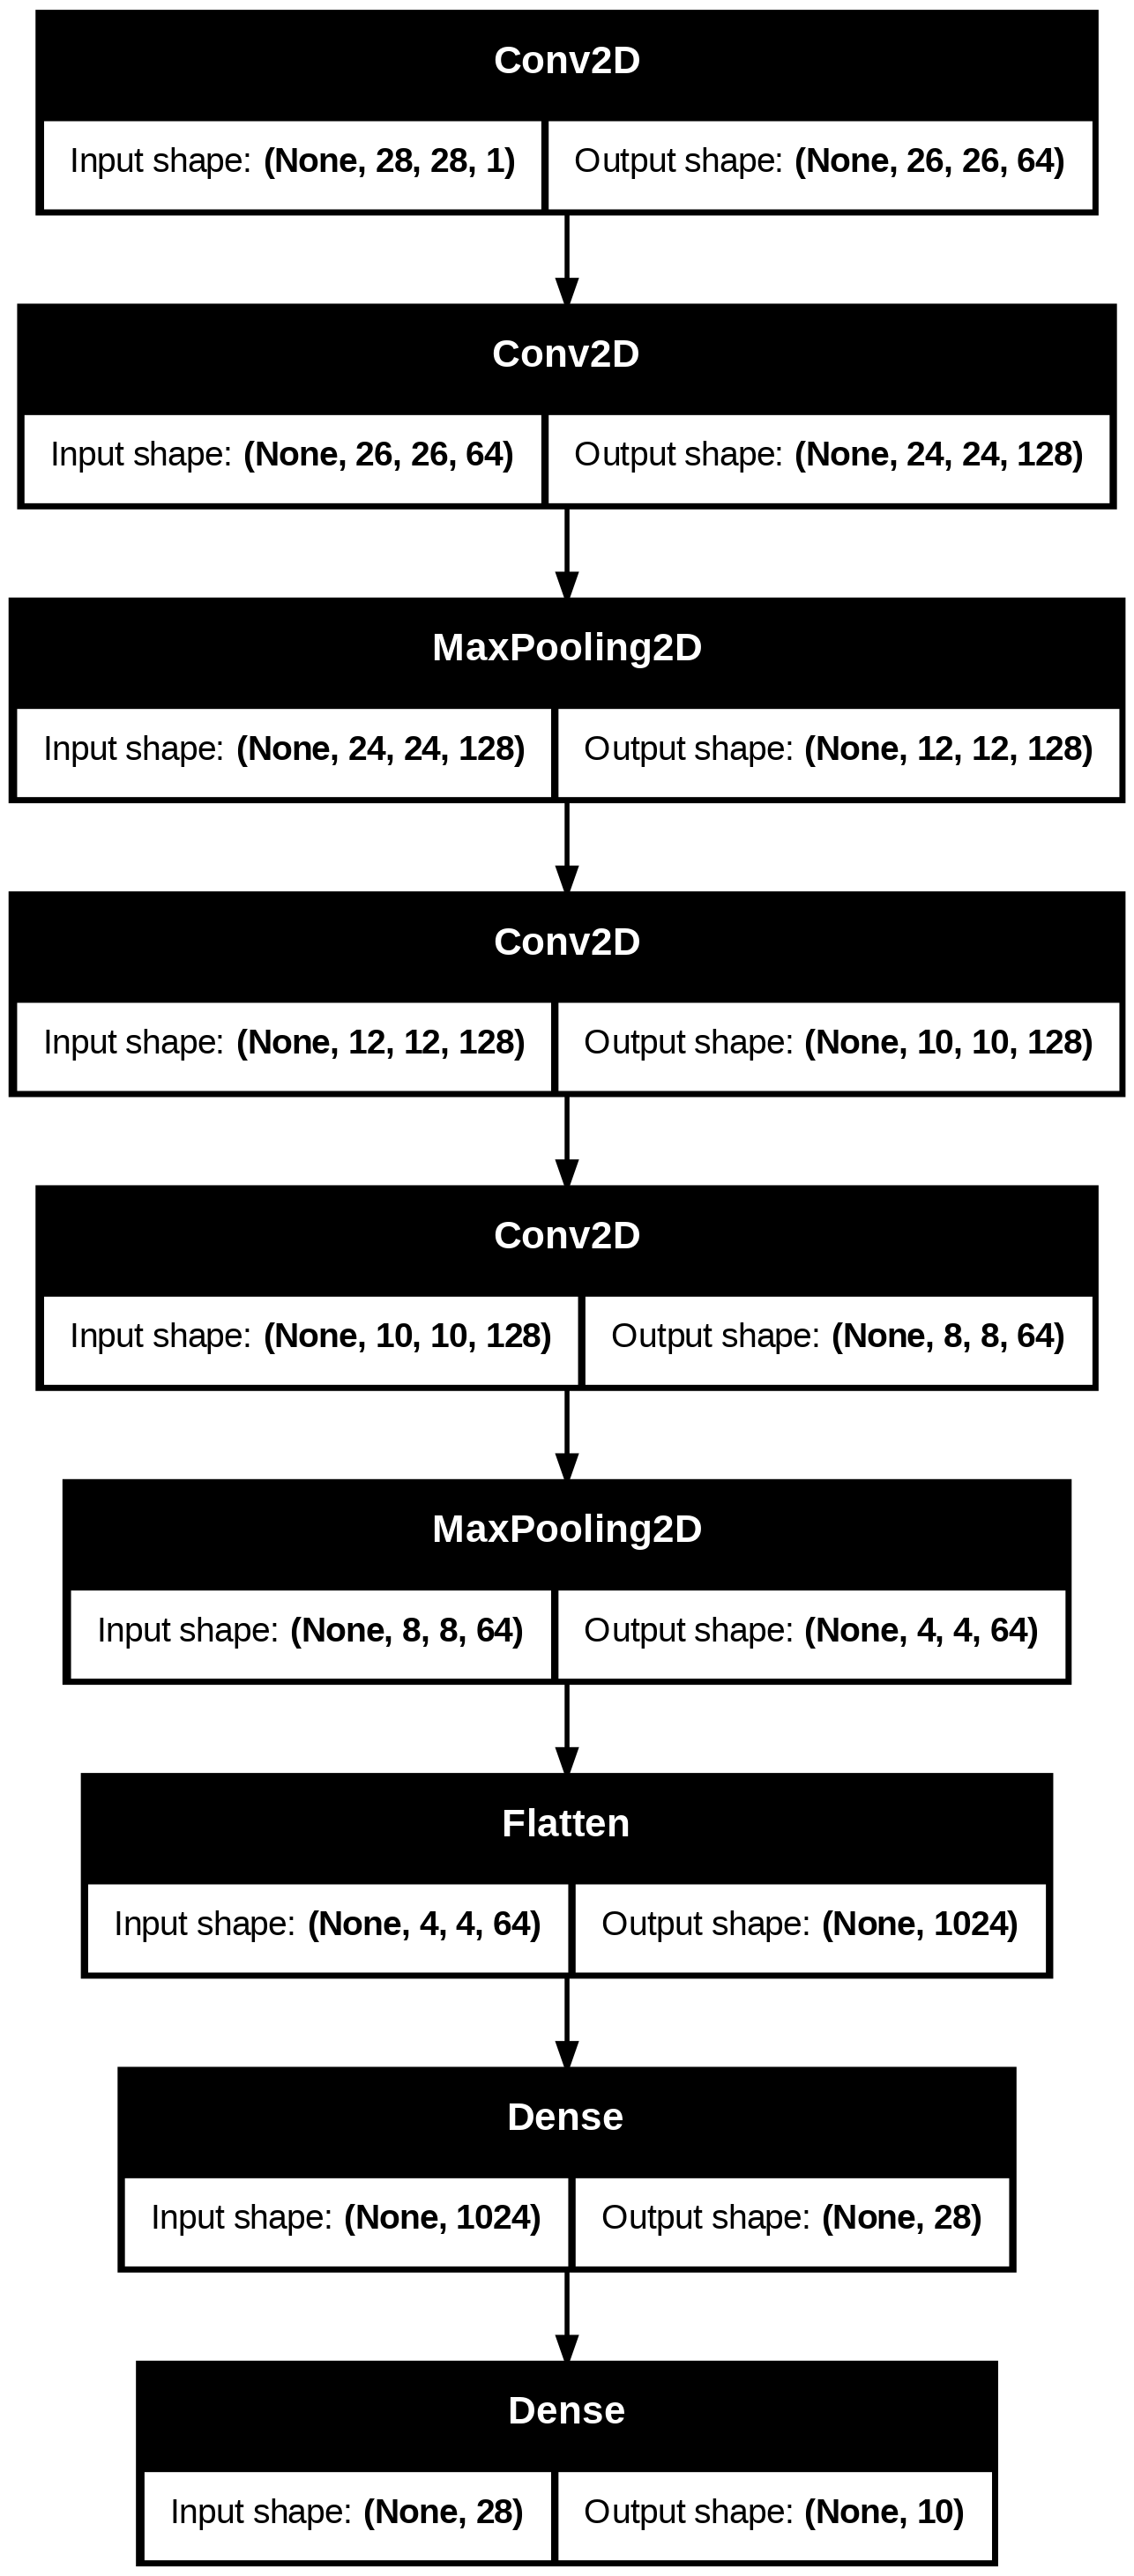

In [ ]:
plot_model(create_model(), to_file='model_architecture.png', show_shapes=True)

## Accuracy

### Training Accuracy

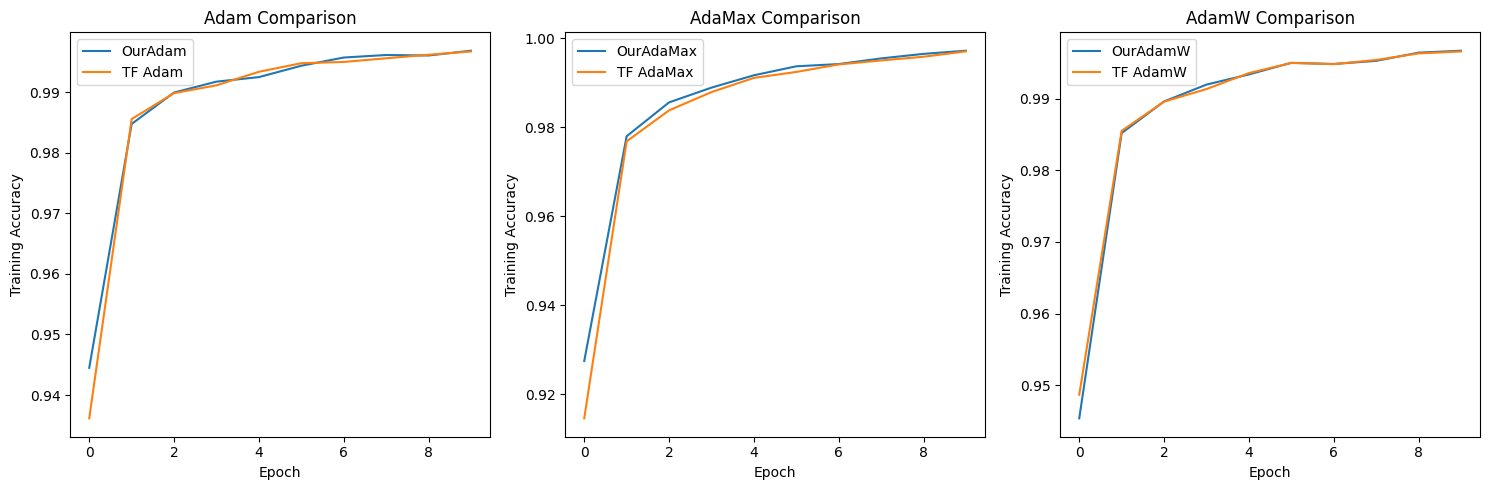

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(our_adam_history.history['accuracy'], label='OurAdam')
plt.plot(tf_adam_history.history['accuracy'], label='TF Adam')
plt.title('Adam Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(our_adamax_history.history['accuracy'], label='OurAdaMax')
plt.plot(tf_adamax_history.history['accuracy'], label='TF AdaMax')
plt.title('AdaMax Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(our_adamw_history.history['accuracy'], label='OurAdamW')
plt.plot(tf_adamw_history.history['accuracy'], label='TF AdamW')
plt.title('AdamW Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()

plt.tight_layout()

### Validation Accuracy

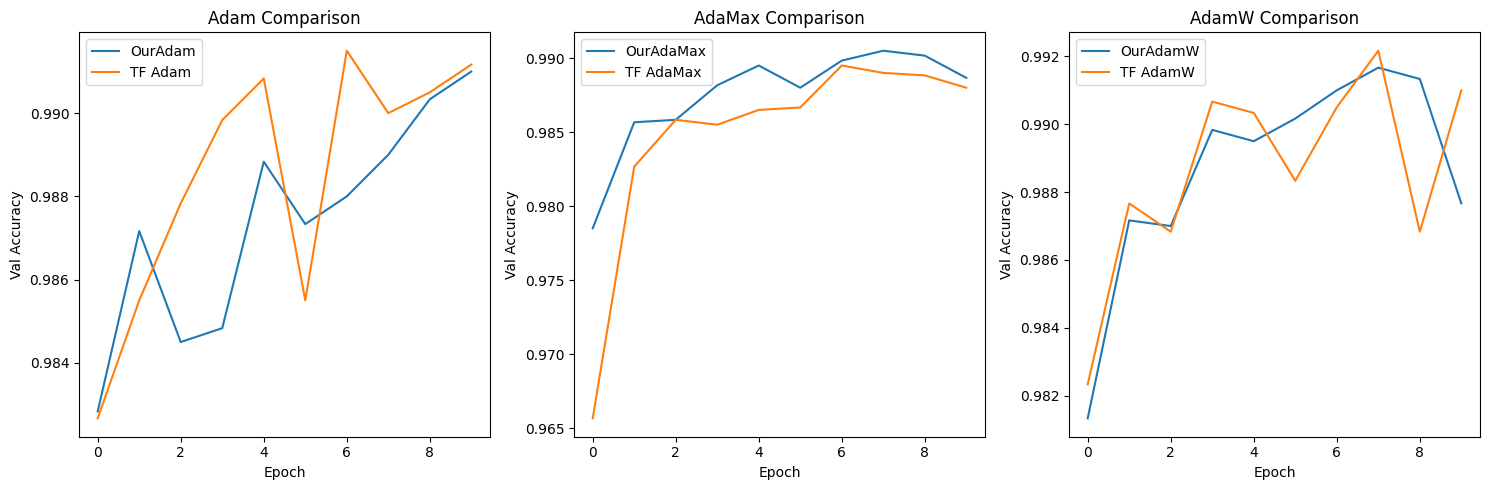

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(our_adam_history.history['val_accuracy'], label='OurAdam')
plt.plot(tf_adam_history.history['val_accuracy'], label='TF Adam')
plt.title('Adam Comparison')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(our_adamax_history.history['val_accuracy'], label='OurAdaMax')
plt.plot(tf_adamax_history.history['val_accuracy'], label='TF AdaMax')
plt.title('AdaMax Comparison')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(our_adamw_history.history['val_accuracy'], label='OurAdamW')
plt.plot(tf_adamw_history.history['val_accuracy'], label='TF AdamW')
plt.title('AdamW Comparison')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.legend()
plt.tight_layout()

## Loss

### Training Loss

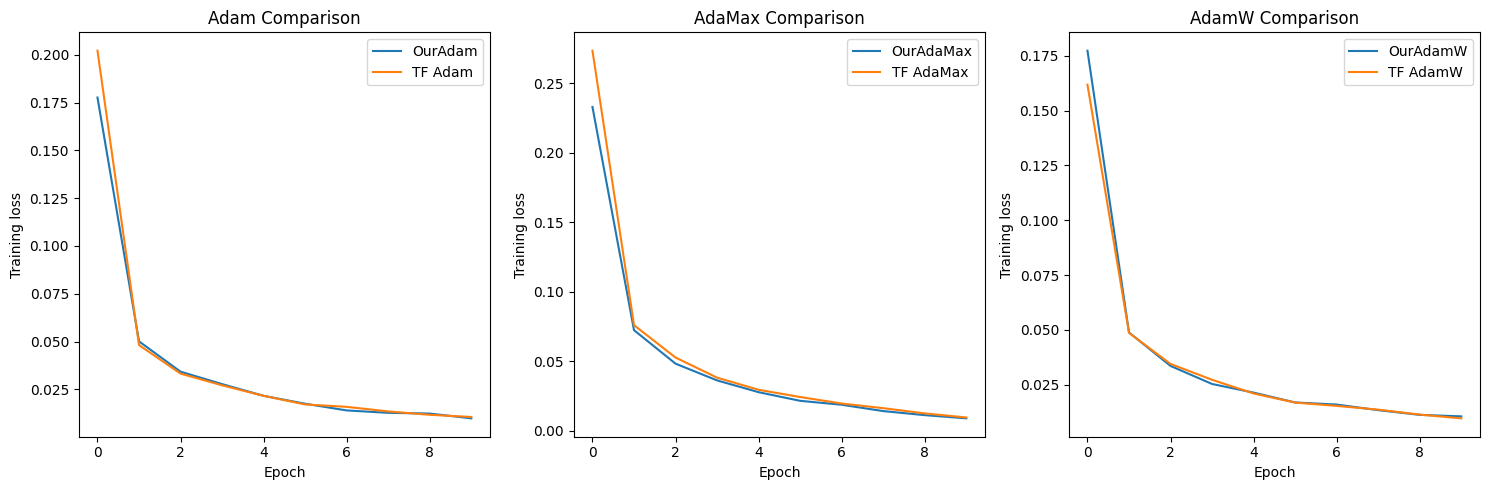

In [ ]:
plt.figure(figsize=(15, 5))

# Left subplot: OurAdam vs TF Adam
plt.subplot(1, 3, 1)
plt.plot(our_adam_history.history['loss'], label='OurAdam')
plt.plot(tf_adam_history.history['loss'], label='TF Adam')
plt.title('Adam Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend()

# Middle subplot: OurAdaMax vs TF AdaMax
plt.subplot(1, 3, 2)
plt.plot(our_adamax_history.history['loss'], label='OurAdaMax')
plt.plot(tf_adamax_history.history['loss'], label='TF AdaMax')
plt.title('AdaMax Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend()

# Right subplot: OurAdamW vs a reference AdamW
plt.subplot(1, 3, 3)
plt.plot(our_adamw_history.history['loss'], label='OurAdamW')
plt.plot(tf_adamw_history.history['loss'], label='TF AdamW')
plt.title('AdamW Comparison')
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.legend()

plt.tight_layout()

### Validation Loss

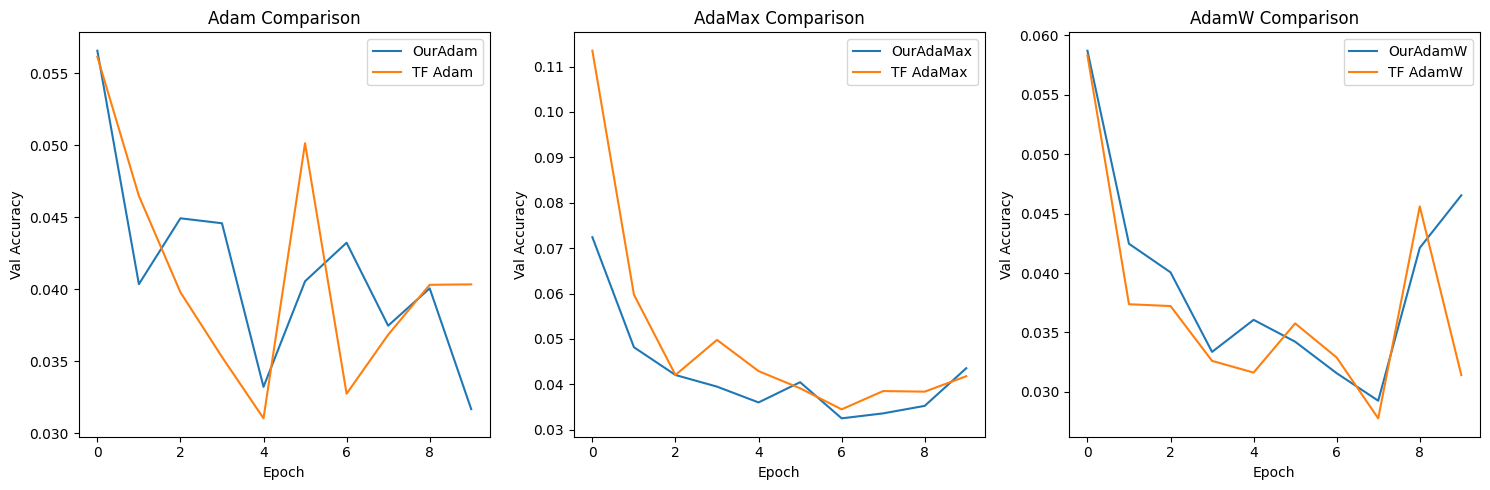

In [ ]:
plt.figure(figsize=(15, 5))

# Left subplot: OurAdam vs TF Adam
plt.subplot(1, 3, 1)
plt.plot(our_adam_history.history['val_loss'], label='OurAdam')
plt.plot(tf_adam_history.history['val_loss'], label='TF Adam')
plt.title('Adam Comparison')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend()

# Middle subplot: OurAdaMax vs TF AdaMax
plt.subplot(1, 3, 2)
plt.plot(our_adamax_history.history['val_loss'], label='OurAdaMax')
plt.plot(tf_adamax_history.history['val_loss'], label='TF AdaMax')
plt.title('AdaMax Comparison')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend()

# Right subplot: OurAdamW vs a reference AdamW
plt.subplot(1, 3, 3)
plt.plot(our_adamw_history.history['val_loss'], label='OurAdamW')
plt.plot(tf_adamw_history.history['val_loss'], label='TF AdamW')
plt.title('AdamW Comparison')
plt.xlabel('Epoch')
plt.ylabel('Val Loss')
plt.legend()

plt.tight_layout()

## Confusion Matrix

### OurAdam vs Tf Adam

#### OurAdam

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


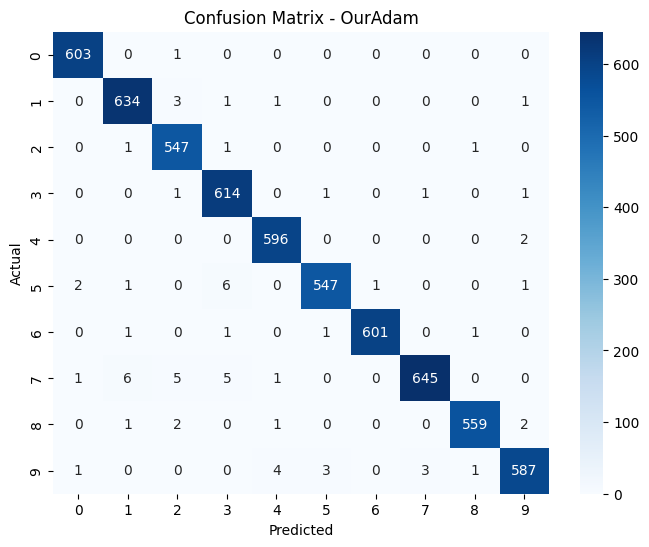

Classification Report - OurAdam

              precision    recall  f1-score   support

           0     0.9934    0.9983    0.9959       604
           1     0.9845    0.9906    0.9875       640
           2     0.9785    0.9945    0.9865       550
           3     0.9777    0.9935    0.9856       618
           4     0.9884    0.9967    0.9925       598
           5     0.9909    0.9803    0.9856       558
           6     0.9983    0.9934    0.9959       605
           7     0.9938    0.9729    0.9832       663
           8     0.9947    0.9894    0.9920       565
           9     0.9882    0.9800    0.9841       599

    accuracy                         0.9888      6000
   macro avg     0.9889    0.9890    0.9889      6000
weighted avg     0.9889    0.9888    0.9888      6000



In [ ]:
def cm_and_cr(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print(f'Classification Report - {title}\n')
    print(classification_report(y_true, y_pred, digits=4))

our_adam = create_model()
our_adam.compile(optimizer=OurAdam(), loss='categorical_crossentropy', metrics=['accuracy'])
our_adam.fit(m_train, y_train, epochs=10, batch_size=64, validation_data=(m_val, y_val), verbose=0)
y_pred_our_adam = np.argmax(our_adam.predict(m_test), axis=-1)

tf_adam = create_model()
tf_adam.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
tf_adam.fit(m_train, y_train, epochs=10, batch_size=64, validation_data=(m_val, y_val), verbose=0)
y_pred_tf_adam = np.argmax(tf_adam.predict(m_test), axis=-1)

labels = np.argmax(y_test, axis=-1)
cm_and_cr(labels, y_pred_our_adam, "OurAdam")

#### Tf Adam

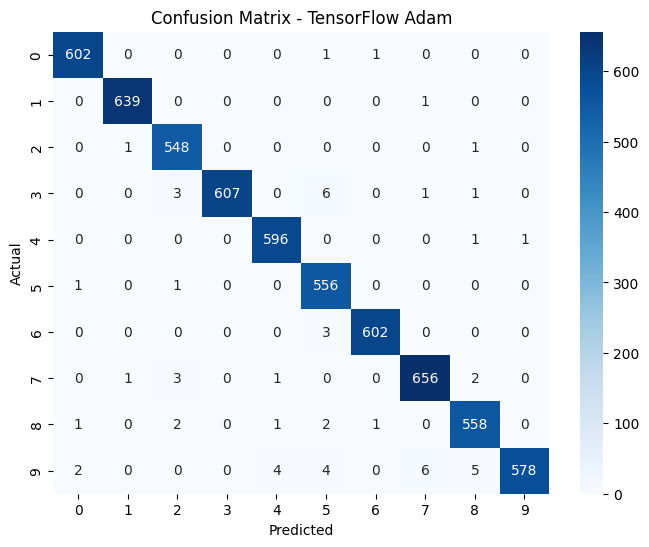

Classification Report - TensorFlow Adam

              precision    recall  f1-score   support

           0     0.9934    0.9967    0.9950       604
           1     0.9969    0.9984    0.9977       640
           2     0.9838    0.9964    0.9901       550
           3     1.0000    0.9822    0.9910       618
           4     0.9900    0.9967    0.9933       598
           5     0.9720    0.9964    0.9841       558
           6     0.9967    0.9950    0.9959       605
           7     0.9880    0.9894    0.9887       663
           8     0.9824    0.9876    0.9850       565
           9     0.9983    0.9649    0.9813       599

    accuracy                         0.9903      6000
   macro avg     0.9901    0.9904    0.9902      6000
weighted avg     0.9904    0.9903    0.9903      6000



In [ ]:
cm_and_cr(labels, y_pred_tf_adam, "TensorFlow Adam")

### OurAdamW vs Tf AdamW

Evaluating OurAdamW optimizer
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Evaluating TensorFlow AdamW optimizer
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


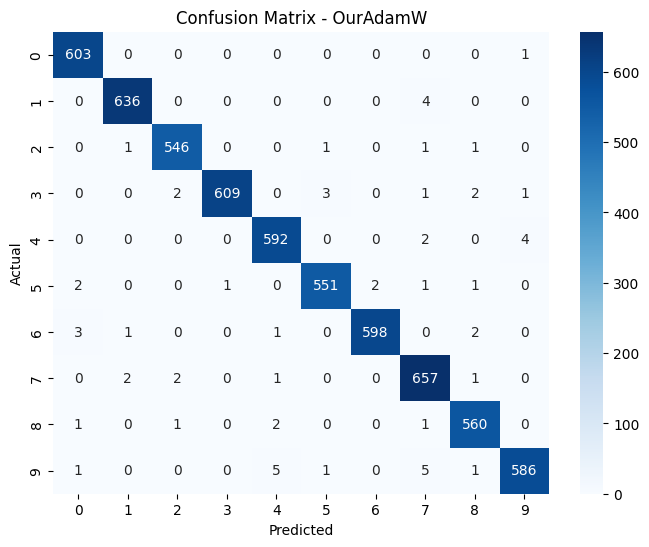

Classification Report - OurAdamW

              precision    recall  f1-score   support

           0     0.9885    0.9983    0.9934       604
           1     0.9938    0.9938    0.9938       640
           2     0.9909    0.9927    0.9918       550
           3     0.9984    0.9854    0.9919       618
           4     0.9850    0.9900    0.9875       598
           5     0.9910    0.9875    0.9892       558
           6     0.9967    0.9884    0.9925       605
           7     0.9777    0.9910    0.9843       663
           8     0.9859    0.9912    0.9885       565
           9     0.9899    0.9783    0.9840       599

    accuracy                         0.9897      6000
   macro avg     0.9898    0.9897    0.9897      6000
weighted avg     0.9897    0.9897    0.9897      6000



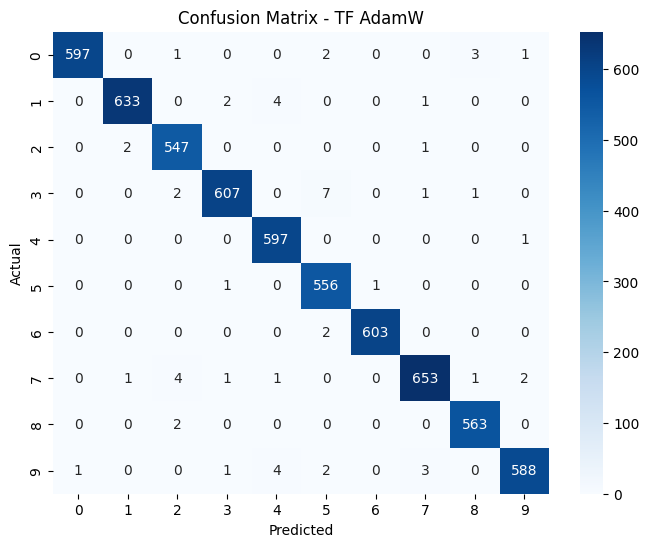

Classification Report - TF AdamW

              precision    recall  f1-score   support

           0     0.9983    0.9884    0.9933       604
           1     0.9953    0.9891    0.9922       640
           2     0.9838    0.9945    0.9892       550
           3     0.9918    0.9822    0.9870       618
           4     0.9851    0.9983    0.9917       598
           5     0.9772    0.9964    0.9867       558
           6     0.9983    0.9967    0.9975       605
           7     0.9909    0.9849    0.9879       663
           8     0.9912    0.9965    0.9938       565
           9     0.9932    0.9816    0.9874       599

    accuracy                         0.9907      6000
   macro avg     0.9905    0.9909    0.9907      6000
weighted avg     0.9907    0.9907    0.9907      6000



In [ ]:
# Confusion Matrix and Classification Report for AdamW

# OurAdamW
print("Evaluating OurAdamW optimizer")
our_adamw_model = create_model()
our_adamw_model.compile(optimizer=OurAdamW(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
our_adamw_model.fit(m_train, y_train, epochs=10, batch_size=64,
                   validation_data=(m_val, y_val), verbose=0)
y_pred_our_adamw = np.argmax(our_adamw_model.predict(m_test), axis=-1)

# TensorFlow AdamW
print("Evaluating TensorFlow AdamW optimizer")
tf_adamw_model = create_model()
tf_adamw_model.compile(optimizer=optimizers.AdamW(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
tf_adamw_model.fit(m_train, y_train, epochs=10, batch_size=64,
                  validation_data=(m_val, y_val), verbose=0)
y_pred_tf_adamw = np.argmax(tf_adamw_model.predict(m_test), axis=-1)

# Plot and print metrics for AdamW
cm_and_cr(labels, y_pred_our_adamw, "OurAdamW")
cm_and_cr(labels, y_pred_tf_adamw, "TF AdamW")

### OurAdamax vs Tf AdaMax

Evaluating OurAdaMax optimizer
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Evaluating TensorFlow AdaMax optimizer
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


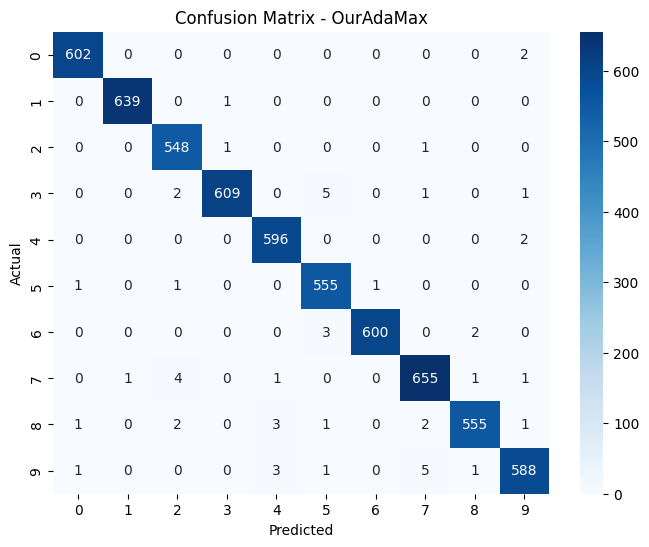

Classification Report - OurAdaMax

              precision    recall  f1-score   support

           0     0.9950    0.9967    0.9959       604
           1     0.9984    0.9984    0.9984       640
           2     0.9838    0.9964    0.9901       550
           3     0.9967    0.9854    0.9910       618
           4     0.9884    0.9967    0.9925       598
           5     0.9823    0.9946    0.9884       558
           6     0.9983    0.9917    0.9950       605
           7     0.9864    0.9879    0.9872       663
           8     0.9928    0.9823    0.9875       565
           9     0.9882    0.9816    0.9849       599

    accuracy                         0.9912      6000
   macro avg     0.9911    0.9912    0.9911      6000
weighted avg     0.9912    0.9912    0.9912      6000



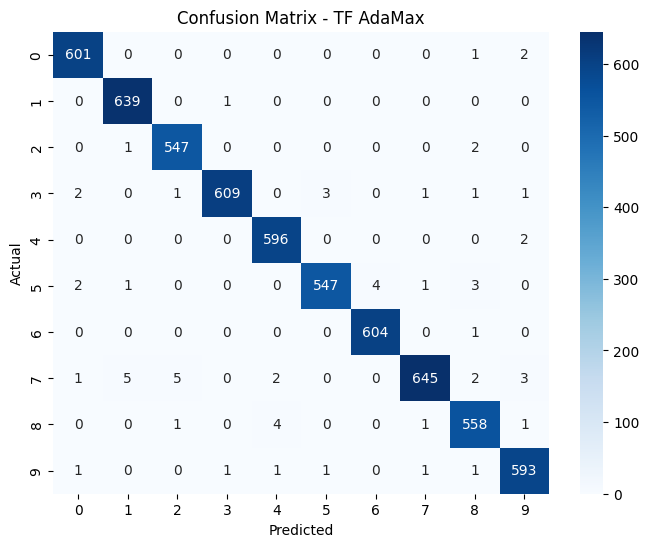

Classification Report - TF AdaMax

              precision    recall  f1-score   support

           0     0.9901    0.9950    0.9926       604
           1     0.9892    0.9984    0.9938       640
           2     0.9874    0.9945    0.9909       550
           3     0.9967    0.9854    0.9910       618
           4     0.9884    0.9967    0.9925       598
           5     0.9927    0.9803    0.9865       558
           6     0.9934    0.9983    0.9959       605
           7     0.9938    0.9729    0.9832       663
           8     0.9807    0.9876    0.9841       565
           9     0.9850    0.9900    0.9875       599

    accuracy                         0.9898      6000
   macro avg     0.9897    0.9899    0.9898      6000
weighted avg     0.9899    0.9898    0.9898      6000



In [ ]:
# OurAdaMax
print("Evaluating OurAdaMax optimizer")
our_adamax_model = create_model()
our_adamax_model.compile(optimizer=OurAdaMax(learning_rate=0.001),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
our_adamax_model.fit(m_train, y_train, epochs=10, batch_size=64,
                    validation_data=(m_val, y_val), verbose=0)
y_pred_our_adamax = np.argmax(our_adamax_model.predict(m_test), axis=-1)

# TensorFlow AdaMax
print("Evaluating TensorFlow AdaMax optimizer")
tf_adamax_model = create_model()
tf_adamax_model.compile(optimizer=optimizers.Adamax(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
tf_adamax_model.fit(m_train, y_train, epochs=10, batch_size=64,
                   validation_data=(m_val, y_val), verbose=0)
y_pred_tf_adamax = np.argmax(tf_adamax_model.predict(m_test), axis=-1)

# Plot and print metrics for AdaMax
cm_and_cr(labels, y_pred_our_adamax, "OurAdaMax")
cm_and_cr(labels, y_pred_tf_adamax, "TF AdaMax")


In [ ]:
from sklearn.metrics import accuracy_score, f1_score

# Collect your results in a list of tuples: (name, training_history, y_predicted)
results = [
    ("OurAdam", our_adam_history, y_pred_our_adam),
    ("TF Adam", tf_adam_history, y_pred_tf_adam),
    ("OurAdamW", our_adamw_history, y_pred_our_adamw),
    ("TF AdamW", tf_adamw_history, y_pred_tf_adamw),
    ("OurAdaMax", our_adamax_history, y_pred_our_adamax),
    ("TF AdaMax", tf_adamax_history, y_pred_tf_adamax),
]

labels_true = np.argmax(y_test, axis=-1)  # Ground truth

for name, hist, y_pred in results:
    train_acc = hist.history['accuracy'][-1]
    val_acc = hist.history['val_accuracy'][-1]
    test_acc = accuracy_score(labels_true, y_pred)
    f1 = f1_score(labels_true, y_pred, average='macro')
    print(f"--- {name} ---")
    print(f"Final Train Accuracy: {train_acc:.4f}")
    print(f"Final Val Accuracy:   {val_acc:.4f}")
    print(f"Test Accuracy:        {test_acc:.4f}")
    print(f"F1 Score (macro):     {f1:.4f}\n")


# Problem

## Problem definitions


In [ ]:
def rosenbrock(x):
    return (1 - x[0])**2 + 100*(x[1] - x[0]**2)**2

def rosen_grad(x):
    dfdx1 = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    dfdx2 = 200*(x[1] - x[0]**2)
    return np.array([dfdx1, dfdx2], dtype=float)

def powell(x):
    x1, x2, x3, x4 = x
    return ((x1 + 10*x2)**2 +
            5*(x3 - x4)**2 +
            (x2 - x3)**4 +
            10*(x1 - x4)**4)

def powell_grad(x):
    x1, x2, x3, x4 = x
    df1 = 2*(x1 + 10*x2) + 40*(x1 - x4)**3
    df2 = 20*(x1 + 10*x2) + 4*(x2 - x3)**3
    df3 = 10*(x3 - x4) - 4*(x2 - x3)**3
    df4 = -10*(x3 - x4) - 40*(x1 - x4)**3
    return np.array([df1, df2, df3, df4], dtype=float)

In [ ]:
def solve_and_track_with_timing(func, grad, x0, optimizer_cls, lr=1e-3, max_iter=5000, tol=1e-8):
    optimizer = optimizer_cls(learning_rate=lr)
    f_history = []
    time_history = []
    path = []
    start_time = time.perf_counter()

    x = tf.Variable(x0, dtype=tf.float32)

    for i in range(max_iter):
        current_time = time.perf_counter() - start_time
        with tf.GradientTape() as tape:
            f_val = func(x.numpy())
        f_history.append(f_val)
        time_history.append(current_time)
        path.append(x.numpy().copy())

        g = grad(x.numpy())
        if np.linalg.norm(g) < tol:
            break

        grads = tf.convert_to_tensor(g, dtype=x.dtype)
        optimizer.apply_gradients([(grads, x)])

    elapsed = time.perf_counter() - start_time
    return {
        "iterations": i+1,
        "final_x": x.numpy().copy(),
        "final_f": func(x.numpy()),
        "time": elapsed,
        "history": np.array(f_history),
        "time_history": np.array(time_history),
        "path": np.array(path)
    }

## Compare on Rosenbrock & Powell


In [ ]:
problems = [
    {"name": "Rosenbrock", "func": rosenbrock, "grad": rosen_grad, "x0": np.array([-1.2, 1.0])},
    {"name": "Powell",     "func": powell,     "grad": powell_grad, "x0": np.array([3.0, -1.0, 0.0, 1.0])}
]

optimizers = [
    OurAdam, OurAdaMax, OurAdamW,
    Adam, Adamax, AdamW
]

results = {}
for pb in problems:
    pb_name = pb["name"]
    results[pb_name] = {}
    print(f"\n=== {pb_name} ===")
    for opt_cls in optimizers:
        res = solve_and_track_with_timing(pb["func"], pb["grad"], pb["x0"].copy(), opt_cls)
        results[pb_name][opt_cls.__name__] = res
        print(f"Optimizer: {opt_cls.__name__}")
        print(f"  # Iterations: {res['iterations']}")
        print(f"  Optimal x  : {res['final_x']}")
        print(f"  Optimal f  : {res['final_f']:.6g}")
        print(f"  CPU time   : {res['time']:.6f} s")


=== Rosenbrock ===
Optimizer: OurAdam
  # Iterations: 5000
  Optimal x  : [-0.30707827  0.09730258]
  Optimal f  : 1.70936
  CPU time   : 43.993347 s
Optimizer: OurAdaMax
  # Iterations: 5000
  Optimal x  : [0.19911991 0.03851836]
  Optimal f  : 0.641537
  CPU time   : 31.769260 s
Optimizer: OurAdamW
  # Iterations: 5000
  Optimal x  : [-0.21763672  0.04947444]
  Optimal f  : 1.48308
  CPU time   : 67.078750 s
Optimizer: Adam
  # Iterations: 5000
  Optimal x  : [-0.30707827  0.09730258]
  Optimal f  : 1.70936
  CPU time   : 43.671475 s
Optimizer: Adamax
  # Iterations: 5000
  Optimal x  : [0.19912004 0.03851841]
  Optimal f  : 0.641536
  CPU time   : 40.660554 s
Optimizer: AdamW
  # Iterations: 5000
  Optimal x  : [-0.28843695  0.0860199 ]
  Optimal f  : 1.66087
  CPU time   : 41.343010 s

=== Powell ===
Optimizer: OurAdam
  # Iterations: 5000
  Optimal x  : [ 1.7492565  -0.15232038  0.8991471   1.3608856 ]
  Optimal f  : 2.56693
  CPU time   : 46.224656 s
Optimizer: OurAdaMax
  # Ite

## Plot: Loss vs. Iterations

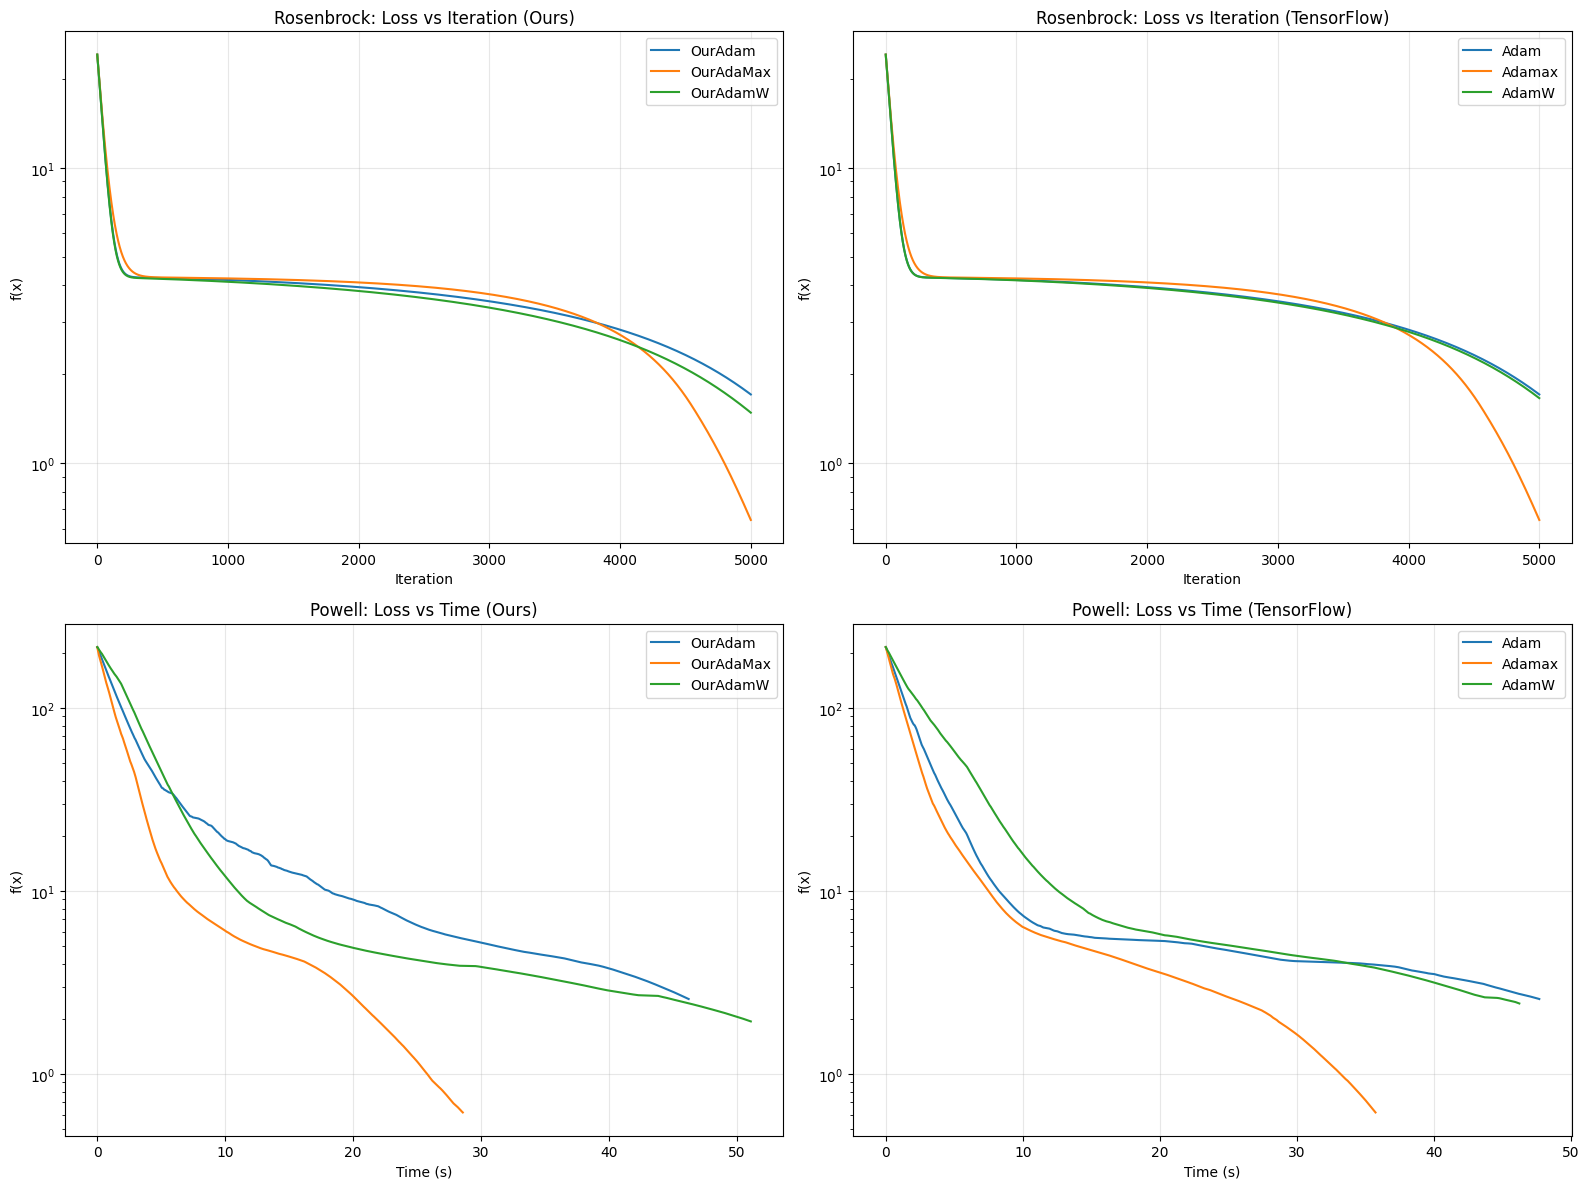

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
ax0, ax1, ax2, ax3 = axes.flatten()

our_models = ["OurAdam", "OurAdaMax", "OurAdamW"]
tensorflow_models = ["Adam", "Adamax", "AdamW"]

# Rosenbrock: Loss vs Iteration (Our Models)
for name in our_models:
    ax0.plot(results["Rosenbrock"][name]["history"], label=name)
ax0.set_title("Rosenbrock: Loss vs Iteration (Ours)")

# Rosenbrock: Loss vs Iteration (TensorFlow Models)
for name in tensorflow_models:
    ax1.plot(results["Rosenbrock"][name]["history"], label=name)
ax1.set_title("Rosenbrock: Loss vs Iteration (TensorFlow)")

# Powell: Loss vs Time (Our Models)
for name in our_models:
    ax2.plot(results["Powell"][name]["time_history"], results["Powell"][name]["history"], label=name)
ax2.set_title("Powell: Loss vs Time (Ours)")

# Powell: Loss vs Time (TensorFlow Models)
for name in tensorflow_models:
    ax3.plot(results["Powell"][name]["time_history"], results["Powell"][name]["history"], label=name)
ax3.set_title("Powell: Loss vs Time (TensorFlow)")

# Shared styling
for ax in [ax0, ax1, ax2, ax3]:
    ax.set_xlabel("Iteration" if "Iteration" in ax.get_title() else "Time (s)")
    ax.set_ylabel("f(x)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale("log")

plt.tight_layout()

## Loss vs. CPU time

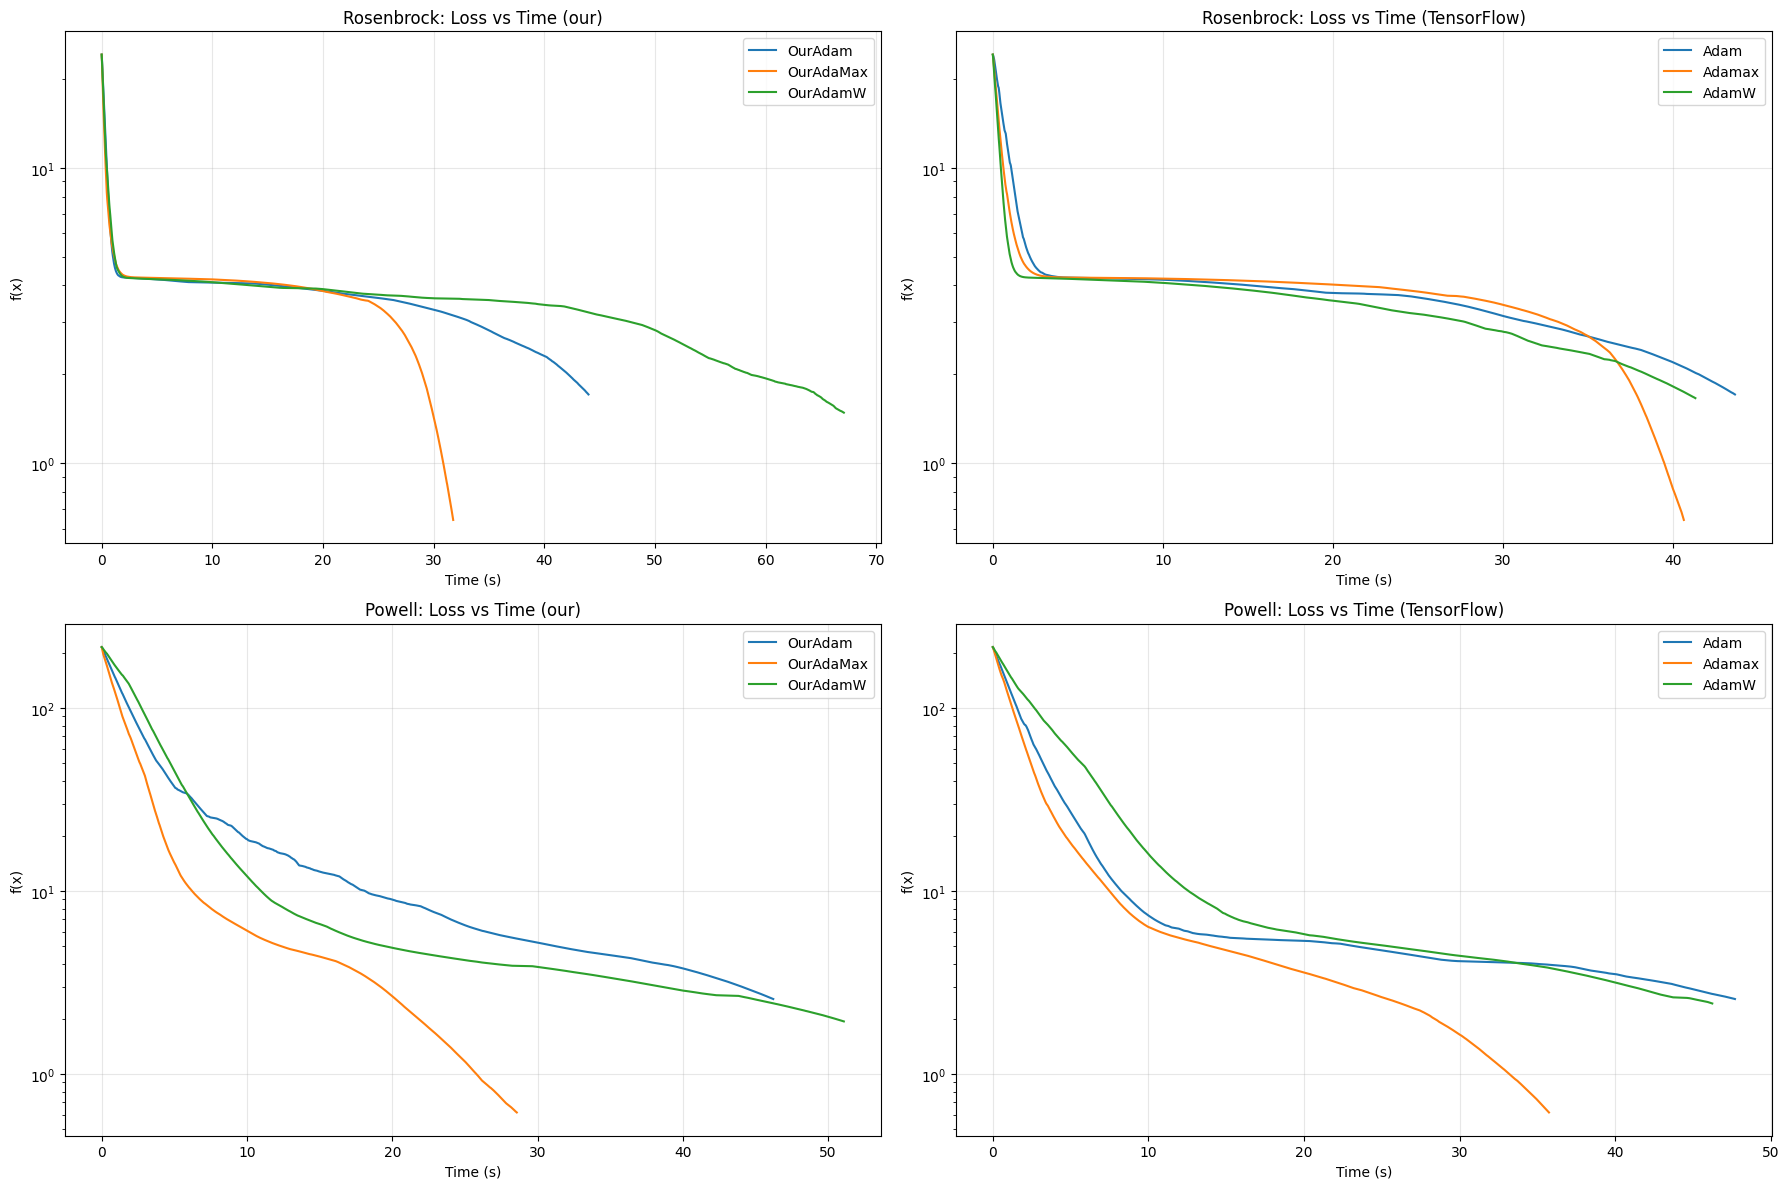

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
ax1, ax2, ax3, ax4 = axes.flatten()

# Rosenbrock: Loss vs Time (our Models)
for name in our_models:
    f_vals = results["Rosenbrock"][name]["history"]
    t_vals = results["Rosenbrock"][name]["time_history"]
    ax1.plot(t_vals, f_vals, label=name)
ax1.set_title("Rosenbrock: Loss vs Time (our)")

# Rosenbrock: Loss vs Time (TensorFlow Models)
for name in tensorflow_models:
    f_vals = results["Rosenbrock"][name]["history"]
    t_vals = results["Rosenbrock"][name]["time_history"]
    ax2.plot(t_vals, f_vals, label=name)
ax2.set_title("Rosenbrock: Loss vs Time (TensorFlow)")

# Powell: Loss vs Time (our Models)
for name in our_models:
    f_vals_p = results["Powell"][name]["history"]
    t_vals_p = results["Powell"][name]["time_history"]
    ax3.plot(t_vals_p, f_vals_p, label=name)
ax3.set_title("Powell: Loss vs Time (our)")

# Powell: Loss vs Time (TensorFlow Models)
for name in tensorflow_models:
    f_vals_p = results["Powell"][name]["history"]
    t_vals_p = results["Powell"][name]["time_history"]
    ax4.plot(t_vals_p, f_vals_p, label=name)
ax4.set_title("Powell: Loss vs Time (TensorFlow)")

# Shared styling
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("f(x)")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale("log")

plt.tight_layout()
plt.show()


## Contour + Path for Rosenbrock (2D)

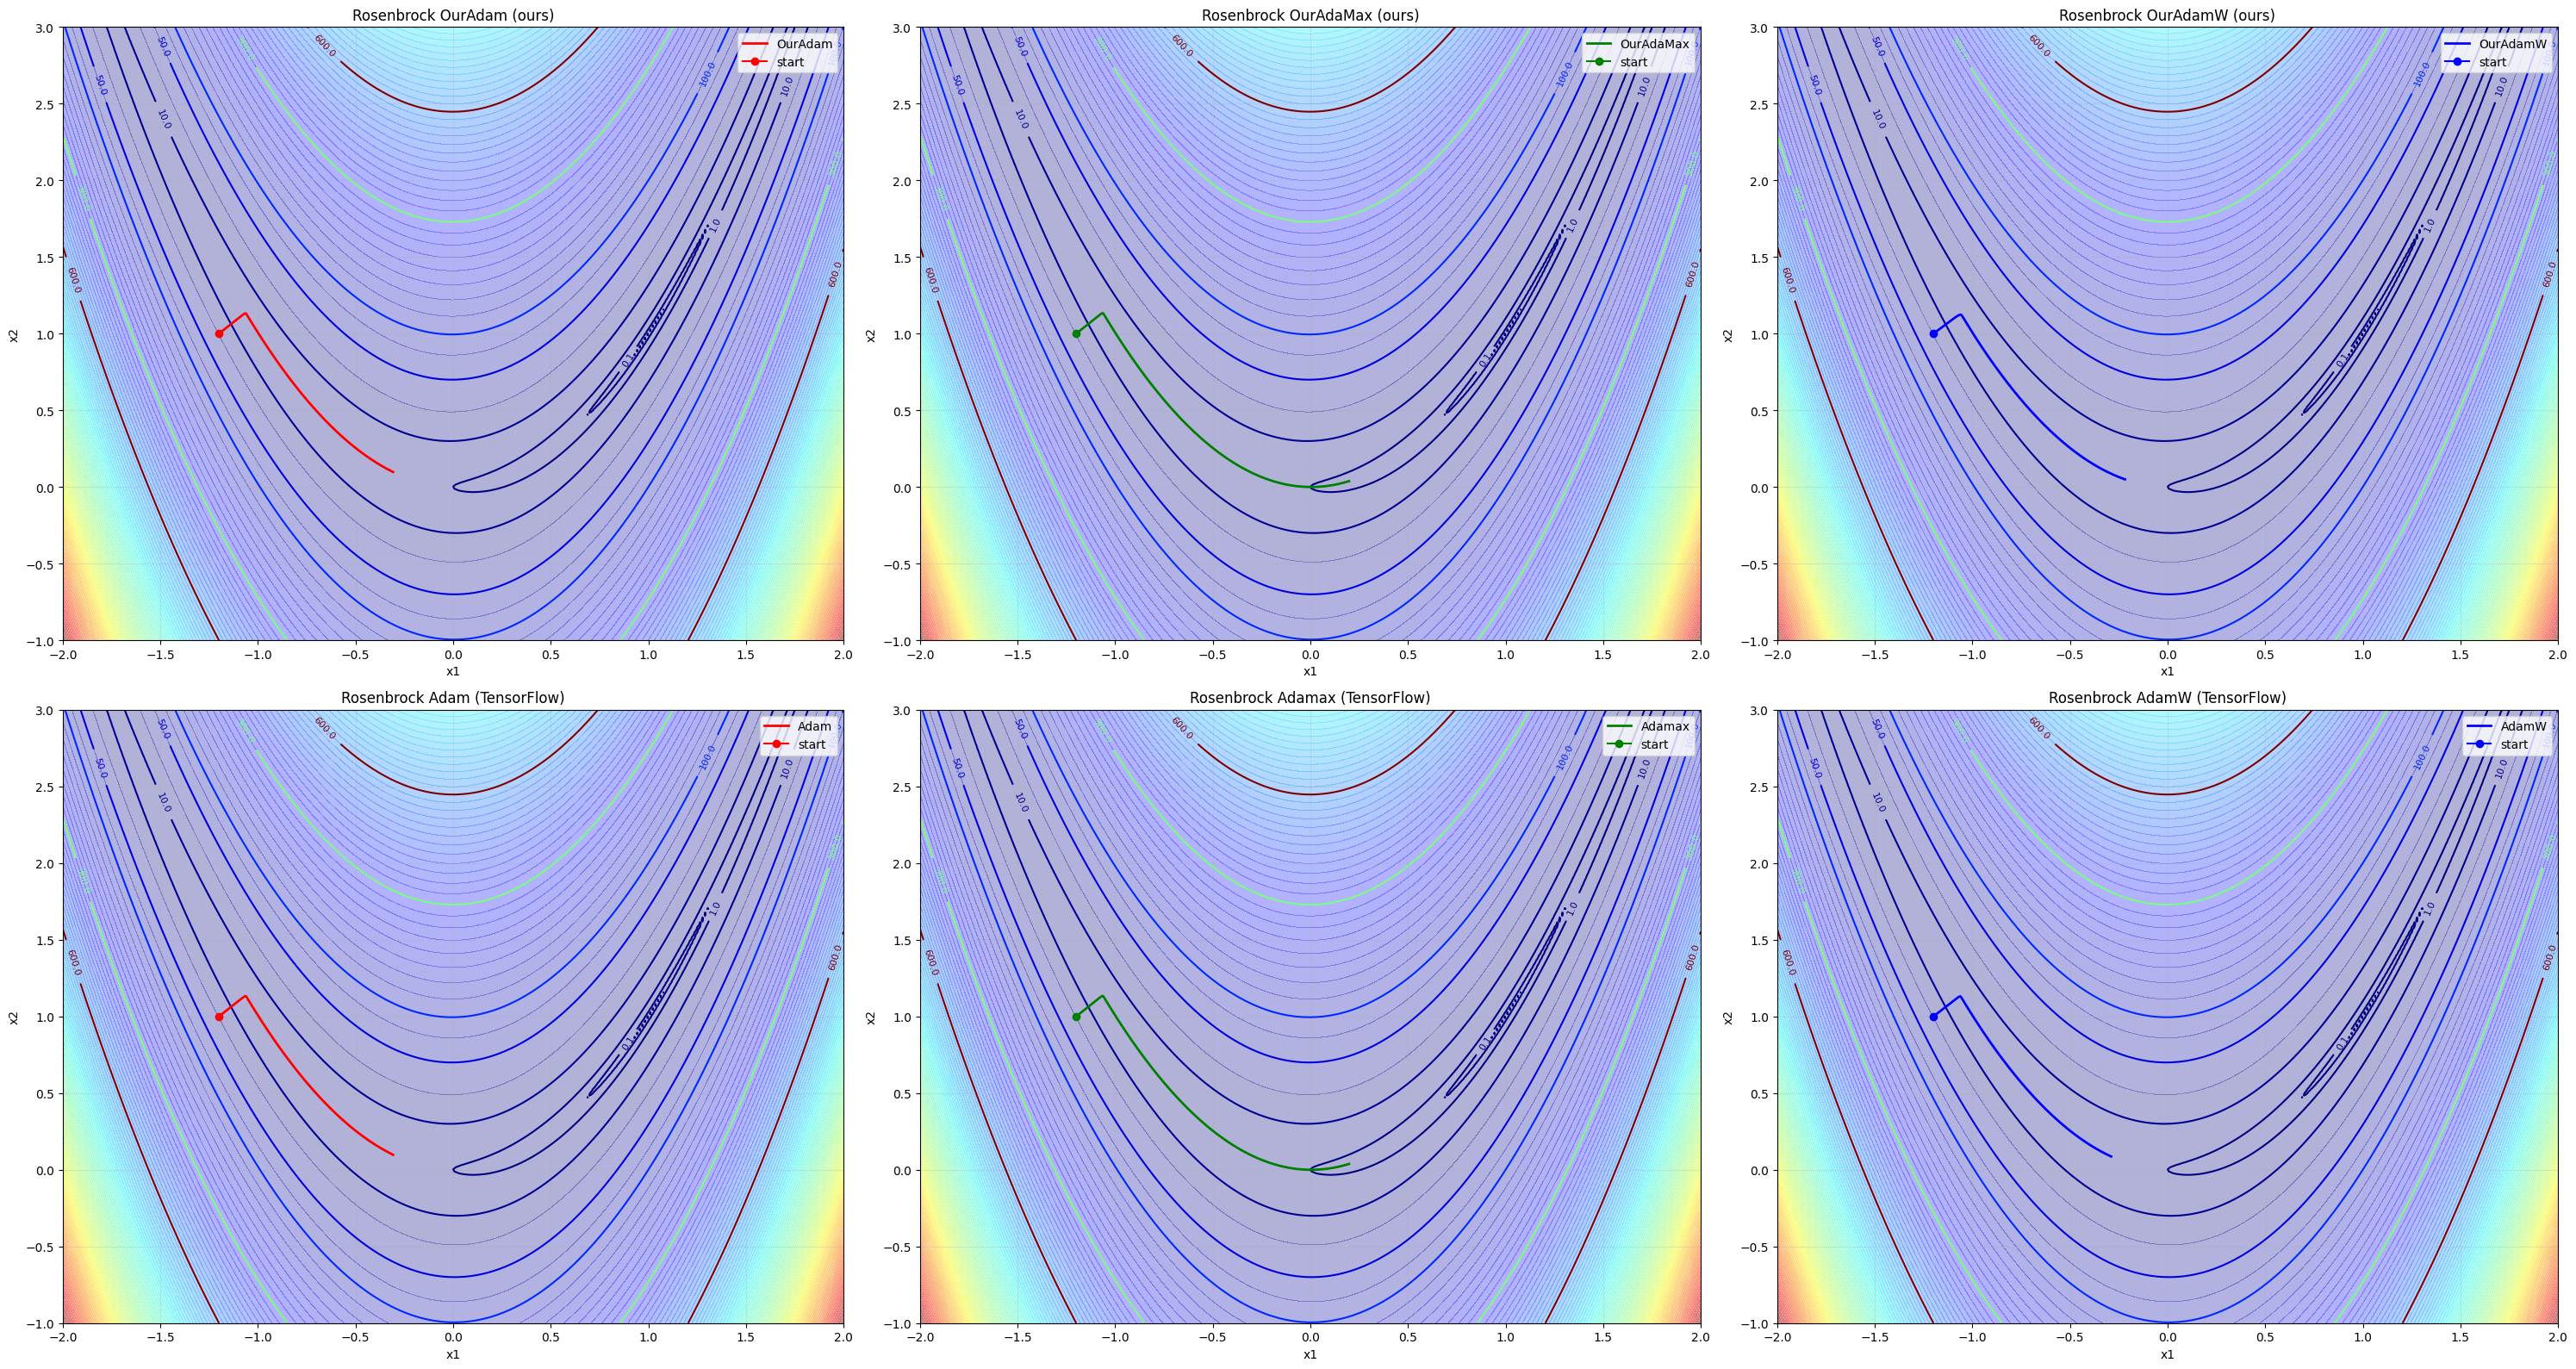

In [ ]:
x_vals = np.linspace(-2, 2, 300)
y_vals = np.linspace(-1, 3, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock([X, Y])
levels = [0.001, 0.01, 0.1, 1, 10, 50, 100, 300, 600]

fig, axes = plt.subplots(2, 3, figsize=(30, 16))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
colors = ["r", "g", "b"]

# Our Models
for i, (color, opt, ax) in enumerate(zip(colors, our_models, [ax1, ax2, ax3])):
    name = opt
    path = results["Rosenbrock"][name]["path"]
    cs = ax.contour(X, Y, Z, levels=levels, cmap="jet")
    ax.contourf(X, Y, Z, levels=100, alpha=0.3, cmap="jet")
    ax.clabel(cs, inline=True, fontsize=8)
    ax.plot(path[:, 0], path[:, 1], color=color, linewidth=2, label=name)
    ax.plot(path[0, 0], path[0, 1], color=color, marker='o', markersize=6, label='start')
    ax.set_title(f"Rosenbrock {name} (ours)")

# TensorFlow Models
for i, (color, opt, ax) in enumerate(zip(colors, tensorflow_models, [ax4, ax5, ax6])):
    name = opt
    path = results["Rosenbrock"][name]["path"]
    cs = ax.contour(X, Y, Z, levels=levels, cmap="jet")
    ax.contourf(X, Y, Z, levels=100, alpha=0.3, cmap="jet")
    ax.clabel(cs, inline=True, fontsize=8)
    ax.plot(path[:, 0], path[:, 1], color=color, linewidth=2, label=name)
    ax.plot(path[0, 0], path[0, 1], color=color, marker='o', markersize=6, label='start')
    ax.set_title(f"Rosenbrock {name} (TensorFlow)")

# Shared styling
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


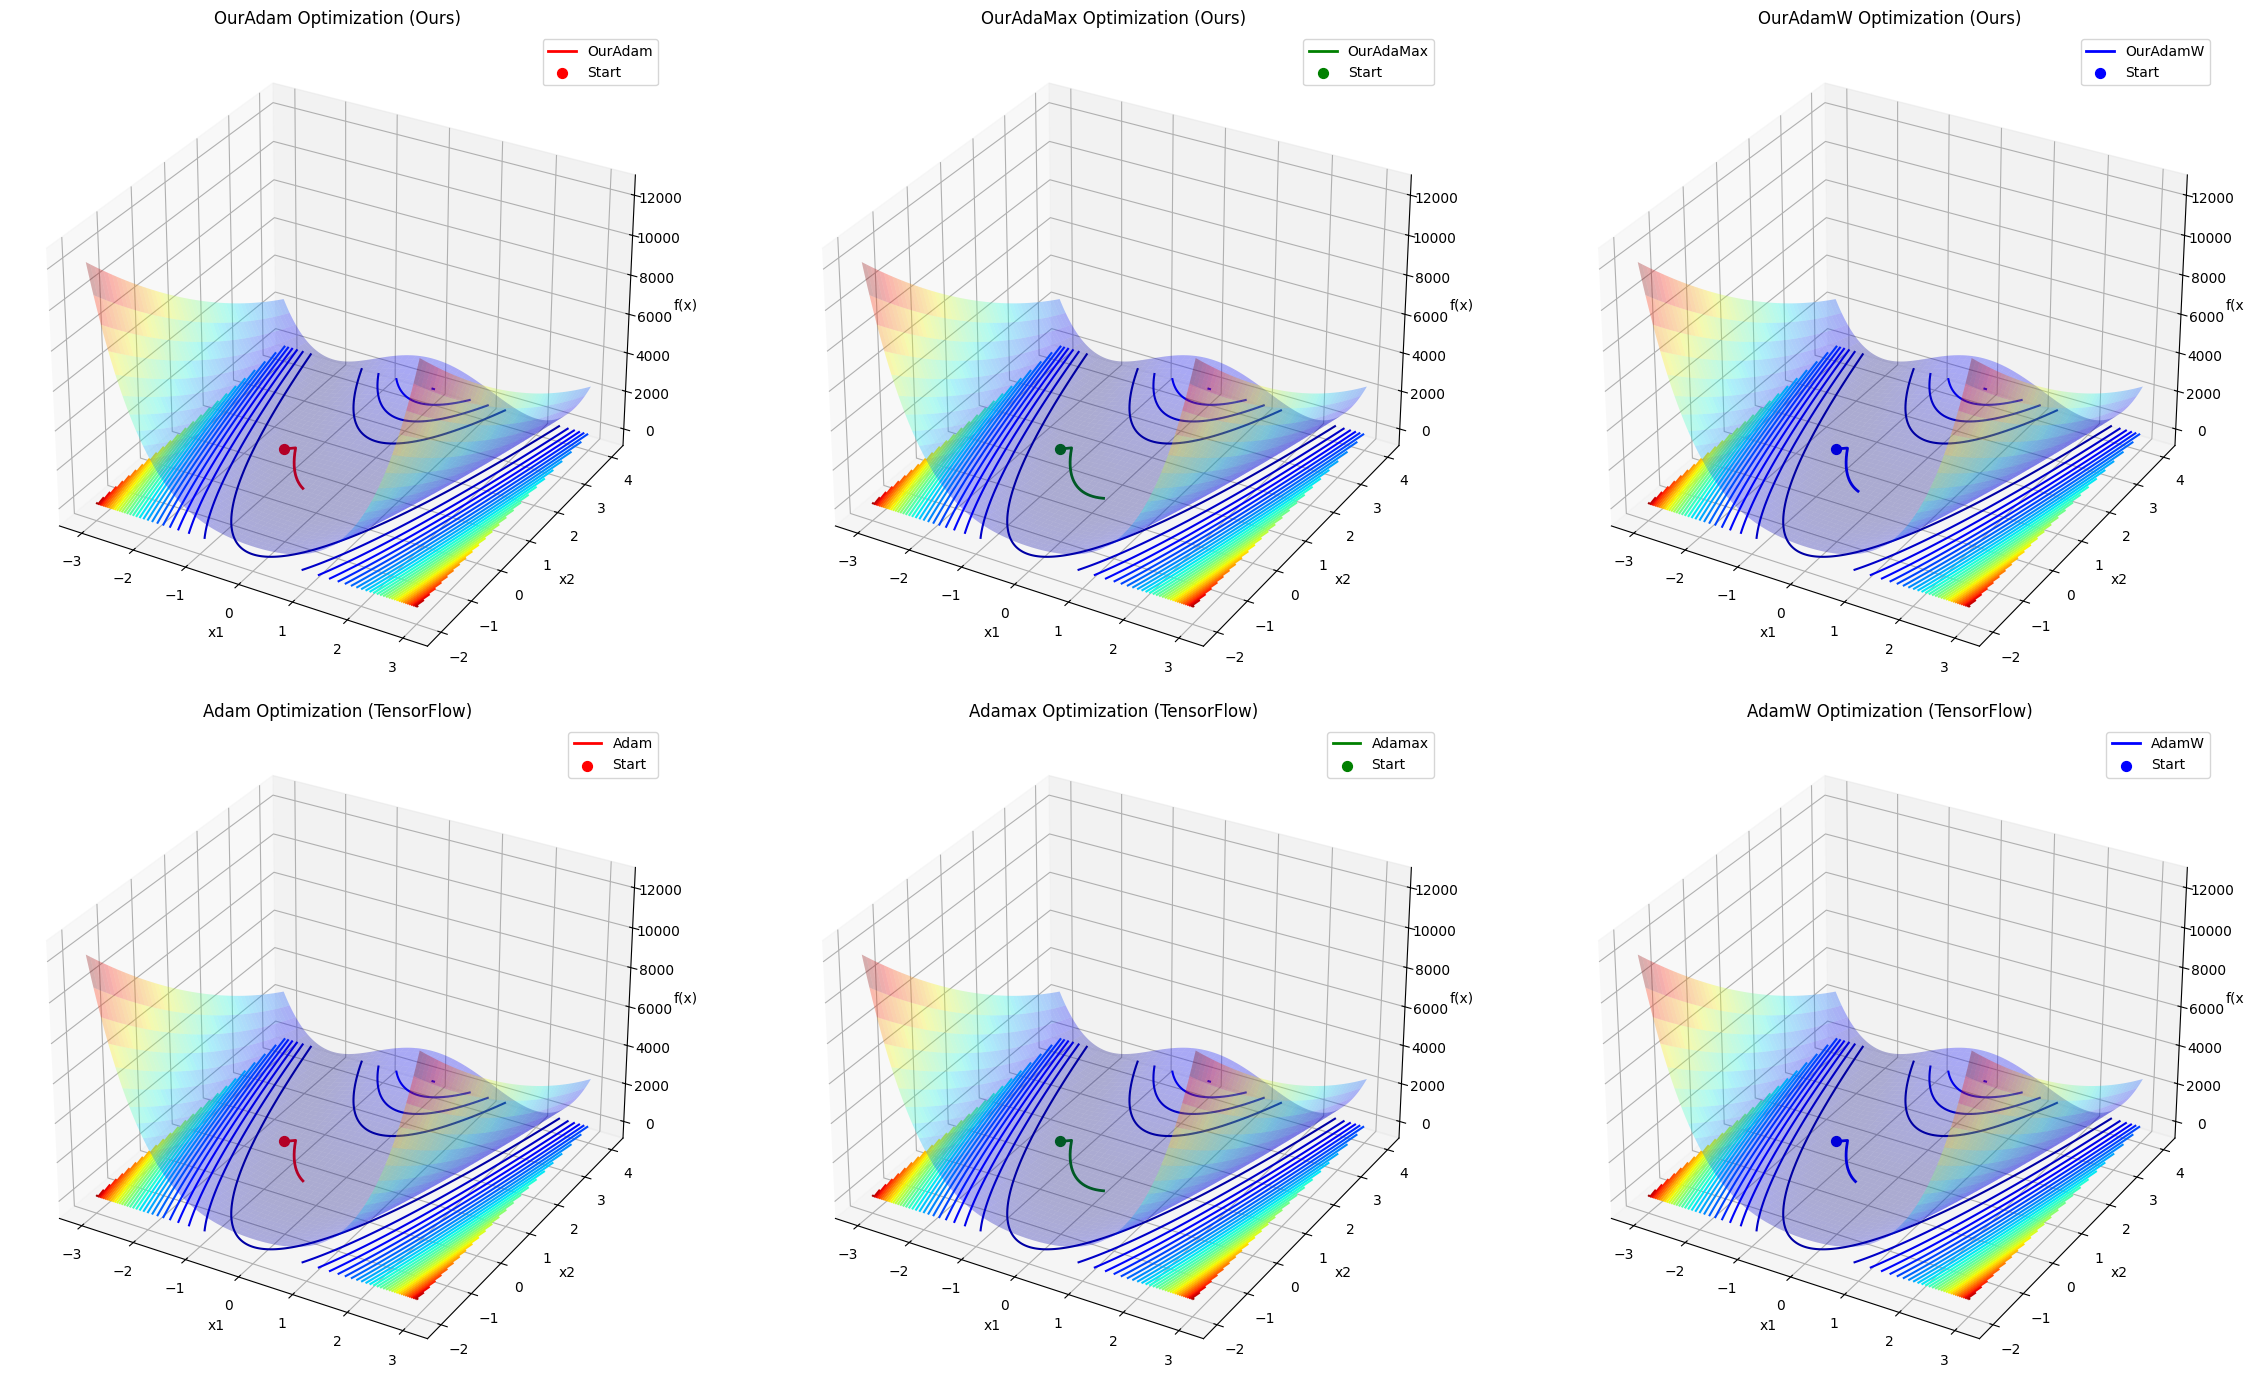

In [ ]:
x_vals = np.linspace(-3, 3, 300)
y_vals = np.linspace(-2, 4, 300)
X, Y = np.meshgrid(x_vals, y_vals)
Z = rosenbrock([X, Y])

fig, axes = plt.subplots(2, 3, figsize=(24, 14), subplot_kw={'projection': '3d'})
ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()
colors = ["r", "g", "b"]

# Plot Our Models
for ax, color, opt in zip([ax1, ax2, ax3], colors, our_models):
    name = opt
    path = results["Rosenbrock"][name]["path"]
    z_path = rosenbrock(path.T)
    ax.plot_surface(X, Y, Z, cmap='jet', alpha=0.3, edgecolor='none')
    ax.contour(X, Y, Z, zdir='z', offset=Z.min() - 10, cmap='jet', levels=30)
    ax.plot(path[:, 0], path[:, 1], z_path, color=color, linewidth=2, label=name)
    ax.scatter(path[0, 0], path[0, 1], z_path[0], color=color, marker='o', s=50, label='Start')
    ax.set_title(f"{name} Optimization (Ours)")

# Plot TensorFlow Models
for ax, color, opt in zip([ax4, ax5, ax6], colors, tensorflow_models):
    name = opt
    path = results["Rosenbrock"][name]["path"]
    z_path = rosenbrock(path.T)
    ax.plot_surface(X, Y, Z, cmap='jet', alpha=0.3, edgecolor='none')
    ax.contour(X, Y, Z, zdir='z', offset=Z.min() - 10, cmap='jet', levels=30)
    ax.plot(path[:, 0], path[:, 1], z_path, color=color, linewidth=2, label=name)
    ax.scatter(path[0, 0], path[0, 1], z_path[0], color=color, marker='o', s=50, label='Start')
    ax.set_title(f"{name} Optimization (TensorFlow)")

# Shared Styling
for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("f(x)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()


## final function values

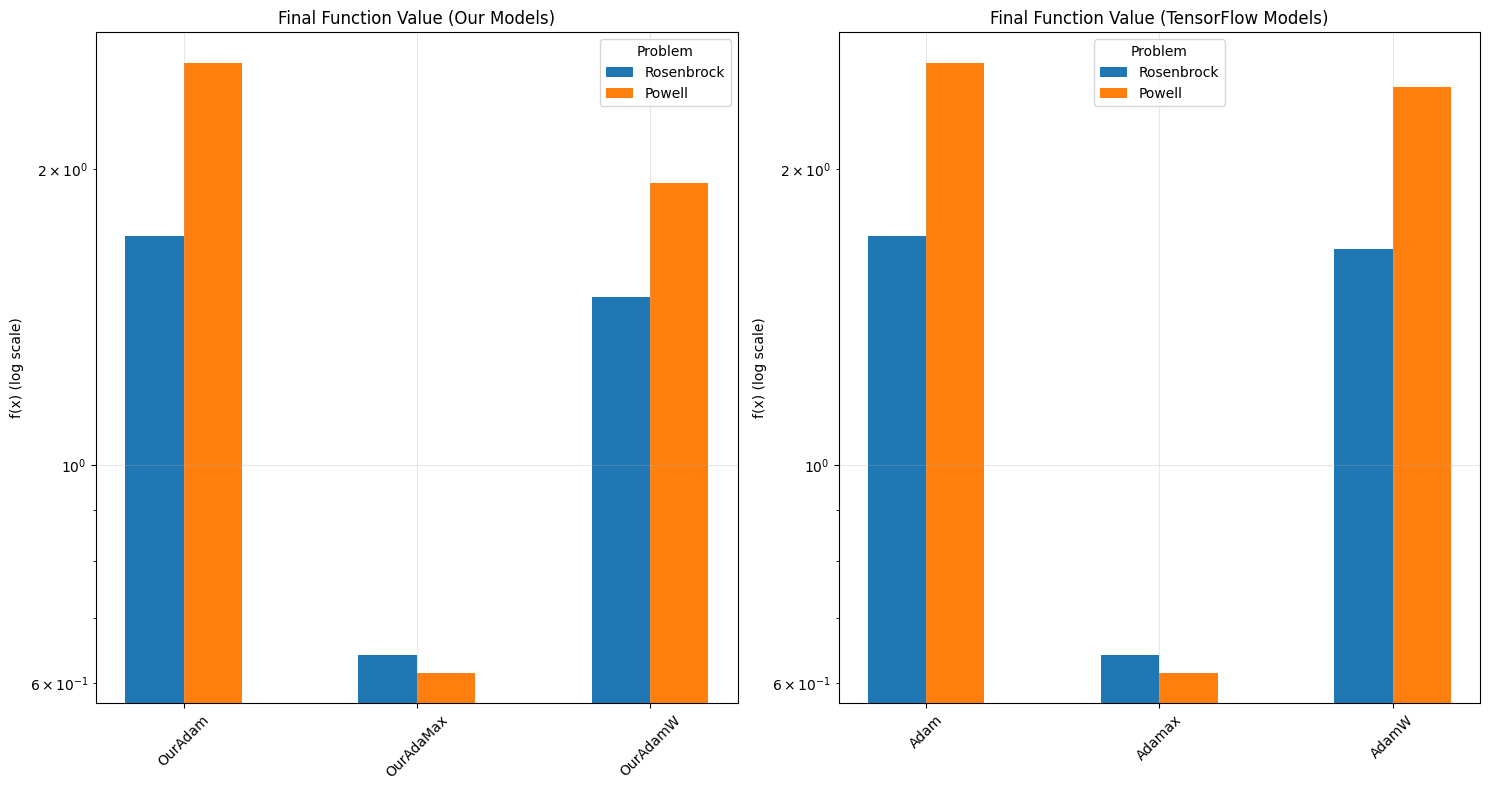

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
bar_width = 0.25

# Our Models
for i, (pb_name, pb_results) in enumerate(results.items()):
    final_fs = [pb_results[opt]["final_f"] for opt in our_models]
    x_positions = np.arange(len(our_models)) + i * bar_width
    axes[0].bar(x_positions, final_fs, width=bar_width, label=pb_name)
axes[0].set_title("Final Function Value (Our Models)")
axes[0].set_xticks(np.arange(len(our_models)) + bar_width / 2)
axes[0].set_xticklabels(our_models, rotation=45)

# TensorFlow Models
for i, (pb_name, pb_results) in enumerate(results.items()):
    final_fs = [pb_results[opt]["final_f"] for opt in tensorflow_models]
    x_positions = np.arange(len(tensorflow_models)) + i * bar_width
    axes[1].bar(x_positions, final_fs, width=bar_width, label=pb_name)
axes[1].set_title("Final Function Value (TensorFlow Models)")
axes[1].set_xticks(np.arange(len(tensorflow_models)) + bar_width / 2)
axes[1].set_xticklabels(tensorflow_models, rotation=45)

# Shared
for ax in axes:
    ax.set_yscale("log")
    ax.set_ylabel("f(x) (log scale)")
    ax.legend(title="Problem")
    ax.grid(True, alpha=0.3)


plt.tight_layout()